In [168]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict
import sys

In [170]:
class BlockingMaze(object):
    """ Implementation of the Blocking Maze """
    def __init__(self):
        # We define the grid for the maze on the left in Example 8.2
        self.left_grid = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [1, 1, 1, 1, 1, 1, 1, 1, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0]])

        # We define the grid for the maze on the right in Example 8.2
        self.right_grid = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 1, 1, 1, 1, 1, 1, 1, 1],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 0, 0]])

        # We initialize the grid with using the left maze first
        self.grid = self.left_grid.copy()
        # Save the size of the maze
        self.grid_height, self.grid_width = self.grid.shape

        # We define the observation space using all empty cells.
        # We consider all cells. Because the environment switch will results in change of the state space
        self.observation_space = np.argwhere(np.zeros((self.grid_height, self.grid_width)) == 0.0).tolist()

        # We define the action space
        self.action_space = {
            "up": np.array([-1, 0]),
            "down": np.array([1, 0]),
            "left": np.array([0, -1]),
            "right": np.array([0, 1])
        }
        self.action_names = ["up", "down", "left", "right"]

        # We define the start state
        self.start_location = [5, 3]

        # We define the goal state
        self.goal_location = [0, 8]

        # We find all wall locations in the grid
        self.walls = np.argwhere(self.grid == 1.0).tolist()

        # We define other useful variables
        self.agent_location = None
        self.action = None

    def reset(self, shift_maze=None):
        """
        Args:
            shift_maze (string): if None, reset function simply set the agent back to the start location
                                 if left, reset function will switch to the maze on the left
                                 if right, reset function will switch to the maze on the right
        """
        if shift_maze is not None:
            if shift_maze == "left":
                self.grid = self.left_grid.copy()
            elif shift_maze == "right":
                self.grid = self.right_grid.copy()
            else:
                raise Exception("Invalid shift operation")

            # reset the shape
            self.grid_height, self.grid_width = self.grid.shape

            # reset the walls
            self.walls = np.argwhere(self.grid == 1.0).tolist()

        # We reset the agent location to the start state
        self.agent_location = self.start_location

        # We set the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (string): name of the action (e.g., "up"/"down"/"left"/"right")
        """
        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the abstract action to movement array
        act_arr = self.action_space[action]

        # Compute the next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([self.grid_height - 1, self.grid_width - 1])).tolist()

        # Check if it crashes into a wall
        if next_agent_location in self.walls:
            # If True, the agent keeps in the original state
            next_agent_location = self.agent_location

        # Compute the reward
        reward = 1 if next_agent_location == self.goal_location else 0

        # Check the termination
        terminated = True if reward == 1 else False

        # Update the action location
        self.agent_location = next_agent_location
        self.action = action

        return next_agent_location, reward, terminated, False, {}

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.agent_location[0], self.agent_location[1]] = 2
        plot_arr[self.goal_location[0], self.goal_location[1]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.01)

In [171]:

class TabularDynaQAgent(object):
    def __init__(self, env, info):
        # Store the environment
        self.env = env

        # Store the maximal learning steps
        self.k = info['learning_step']

        # Store the planning steps
        self.n = info['planning_step']

        # Store the Q-learning step size alpha
        self.alpha = info['alpha']

        # Store the discount factor
        self.gamma = info['gamma']

        # Initialize the epsilon for epsilon-greedy policy
        self.epsilon = info['epsilon']

        # Initialize the switch time
        self.maze_switch_time = info['switch_time_step']
        # self.plan_rand_gene = np.random.RandomState(info.get('planning_random_seed',42))
        
        # Compute total number of the state
        self.state_num = len(self.env.observation_space)

        # Compute the number of the actions
        self.action_num = len(self.env.action_names)

        # Initialize the Q(s, a): a table stores (s, a)
        self.q_table = np.zeros((self.state_num, self.action_num))
        

        self.model = {}

    def _get_state_idx(self, state):
        """
        Function returns the index of the state in the q table (i.e., row index)
        Args:
             state (tuple): a tuple contains the state
        """
        state = list(state)
        return self.env.observation_space.index(state)

    def _get_action_idx(self, action):
        """
        Function returns the index of the action in the q table (i.e., column index)
        Args:
            action (string): action name
        """
        return self.env.action_names.index(action)

    def epsilon_greedy_policy(self, state):
        """
        Function implements the epsilon-greedy policy
        Args:
            state (tuple): a tuple contains the state
        """
        if random.random() < self.epsilon:  # with p = epsilon, we randomly sample an action
            return random.sample(self.env.action_names, 1)[0]
        else:  # With p = 1 - epsilon, derive a greedy policy from the Q table
            state_idx = self._get_state_idx(state)
            q_values = self.q_table[state_idx]
            max_action_list = np.where(q_values == q_values.max())[0].tolist()
            max_action_idx = random.sample(max_action_list, 1)[0]
            return self.env.action_names[max_action_idx]  # break ties

    def update_model(self, s, a, r, next_s):
        """
        Args:
            s (list): contains the location of the agent
            a (string): name of the action
            r (int): reward
            next_s (list): contains the location of the agent after taking the action
        """
        """ CODE HERE: adding transition to the model """
   
        s=tuple(s)
        next_s=tuple(next_s)
        if s not in self.model:
           
            self.model[s]={}

        self.model[s][a]=(r,next_s)
     
 
    def update_q_table(self, s, a, r, next_s):
        """
        Args:
            s (list): contains the location of the agent
            a (string): name of the action
            r (int): reward
            next_s (list): contains the location of the agent after taking the action
        """
        """ CODE HERE: Q-learning """
    
        s_idx=self._get_state_idx(s)
        next_s_idx=self._get_state_idx(next_s)

        a_idx=self._get_action_idx(a)
        
        max_q= max([self.q_table[next_s_idx][self._get_action_idx(a)] for a in self.env.action_names])

        self.q_table[s_idx][a_idx]=self.q_table[s_idx][a_idx]+self.alpha*(r+self.gamma*max_q-self.q_table[s_idx][a_idx])
        
    def run_planning_step(self):
        """ CODE HERE: planning step see (f) in the pseudocode """
        for _ in range(self.n):
            
            mylist=list(self.model.keys())
            state = mylist.pop(random.randrange(len(mylist)))
            state=tuple(state)
           
            action = random.sample(list(self.model[state].keys()), 1)[0]
         
            reward, next_state = self.model[state][action]
            next_state=tuple(next_state)

            self.update_q_table(state, action, reward, next_state)

    def run(self):

    
        # record the reward
        cumulative_reward = 0

        # save the cumulative reward w.r.t. each time step
        cumulative_rewards_wrt_time_steps = np.zeros(self.k)

        # Dyna-Q starts
        state, _ = self.env.reset()
        state=tuple(state)
        
        for t in range(self.k):
           
            action=self.epsilon_greedy_policy(state)
            # take the action and observe reward and next state
            next_state, reward, terminated ,_,_= self.env.step(action)
            next_state=tuple(next_state)
            
            # new_action=self.epsilon_greedy_policy(next_state)
    
            self.update_q_table(state,action,reward,next_state)

            self.update_model(state,action,reward,next_state)

            self.run_planning_step()
            
            """ SAVE PLOTTING RESULTS DO NOT CHANGE """
            # store the cumulative rewards
            cumulative_reward += reward
            cumulative_rewards_wrt_time_steps[t] = cumulative_reward

            if t == self.maze_switch_time:
                state, _ = self.env.reset(shift_maze="right")
            else:
                if terminated:
                    state, _ = self.env.reset()
                    
                else:
                    state = next_state
              

        return cumulative_rewards_wrt_time_steps

In [182]:


def e_greedy(Q, epsilon, nA):
  
  
    def policy(state):
        
        A = np.ones(nA) * (epsilon/nA)
        best_action = np.argmax(Q[state])
        A[best_action] += (1.0 - epsilon)
        return A
        
    return policy

def n_stepSarsa(env,n,num_of_episodes,e,gamma,alpha):
    Q=defaultdict(int)
    policy=e_greedy(Q,e,4)
    max_re=0
    rew_sum=0
    
  

    for ep in range(num_of_episodes):
        state,_=env.reset()
        state=tuple(state)
        actions_dic={}
        rewards={}
        states={}
        G=0
        time_step=[]
      
      
        action_probs = policy(state)
       
        action = np.random.choice(list(env.action_space.keys()), p=action_probs)
        ep_length=np.zeros(num_of_episodes)
        actions_dic[0]=action
        states[0]=state
        reward_per_ep=0
        T=6000
        tau=0
        t=-1
        rew_ep=np.zeros(T)
        while tau<(T-1):
            t+=1
            if t<T:
                next_s,reward,terminated,_,_=env.step(action)
                next_s=tuple(next_s)
                rewards[(t+1) %n]=reward
                states[(t+1) %n]=next_s
                ep_length[ep]=t

                rew_sum +=reward
                rew_ep[t]=rew_sum


                if terminated:
                    t +=1
                    time_step.append(t)
                else:
                    nex_action_probs=policy(next_s)
                    new_action=np.random.choice(list(env.action_space.keys()), p=nex_action_probs)
                    actions_dic[(t+1) %n]=new_action
            tau=t-n+1

            if tau >=0:
                G = np.sum([gamma**(i-tau-1)*rewards[i%n] for i in range(tau+1, min(tau+n, T)+1)])

            if tau+n<T:
                G +=gamma**n *Q[states[(tau+n) % n]]
            tau_states,tau_actions=states[tau % n],actions_dic[tau %n]

            Q[(tau_states,tau_actions)] +=alpha*(G-Q[(tau_states,tau_actions)])
        if reward_per_ep>max_re:
            max_re=reward_per_ep
        # rew_ep.append(reward_per_ep)

    return Q,max_re,ep_length,time_step
            


        
    

In [194]:

class dynavssarsa(TabularDynaQAgent):
    def __init__(self, env, info):
        super().__init__(env, info)
        
        # add one parameter "kappa" to compute the bonus reward defined as: r + kappa * sqrt(elapsed time steps)
        self.kappa = info['kappa']
        self.t=0
        
    def update_model(self, s, a, r, next_s, last_t):
        """
        Args:
            s (list): contains the location of the agent
            a (string): name of the action
            r (int): reward
            next_s (list): contains the location of the agent after taking the action
            last_t (int): the real time step that the transition is encountered
        """
        """ CODE HERE """
        s=tuple(s)
        next_s=tuple(next_s)
        if s not in self.model:
            self.model[s]={}

        self.model[s][a]=(r,next_s,last_t)
                
        # similar to the previous update. This time add last_t as one component
    
        
    def run_planning_step(self, current_t):
        """
        Args:
            current_t (int): current time step in the learning process. We use it as well as the time recorded in
            each transition to compute the elasped time. 
        """

        for _ in range(self.n):

            """ CODE HERE: Dyna-Q with bonus reward no footnote """
            # randomly sample a previously observe state, you can sample it from the self.model.keys()
            mylist=list(self.model.keys())
            state = mylist.pop(random.randrange(len(mylist)))
            state=tuple(state)
   
            action = random.sample(list(self.model[state].keys()), 1)[0]
            reward, next_state ,t = self.model[state][action]
            next_state=tuple(next_state)

            # compute the "bonus" reward = r + kappa * sqrt(time elasped)
            reward += self.kappa * np.sqrt(current_t-t)

            # update the Q table using Q-learning
            self.update_q_table(state, action, reward, next_state)
       
            
    def run(self):

        # record the reward
        cumulative_reward = 0

        # save the cumulative reward w.r.t. each time step
        cumulative_rewards_wrt_time_steps = np.zeros(self.k)

        # Dyna-Q starts
        state, _ = self.env.reset()
        
       
        for t in range(self.k):
            
            action=self.epsilon_greedy_policy(state)
            # take the action and observe reward and next state
            next_state, reward, terminated,_,_ = self.env.step(action)
           
            # update the Q table using Q-learning
            self.update_q_table(state,action,reward,next_state)
            # update model
            self.update_model(state,action,reward,next_state,t)

            self.run_planning_step(t)

            # uncomment print info for debug
            # print(f"t = {t}, s = {state}, a = {action}, r = {reward}, next_s = {next_state}, done = {terminated}")
            
            """ SAVE PLOTTING RESULTS DO NOT CHANGE """
            # store the cumulative rewards
            cumulative_reward += reward
            cumulative_rewards_wrt_time_steps[t] = cumulative_reward

            # reset the environment
            if t == self.maze_switch_time:
                state, _ = self.env.reset(shift_maze="right")
            else:
                if terminated:
                    state, _ = self.env.reset()
                    
                else:
                    state = next_state
        
        return cumulative_rewards_wrt_time_steps

In [183]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    # save the figure
    plt.savefig(f"{fig_title}.png", dpi=200)

    plt.show()

100%|██████████| 10/10 [04:42<00:00, 28.21s/it]


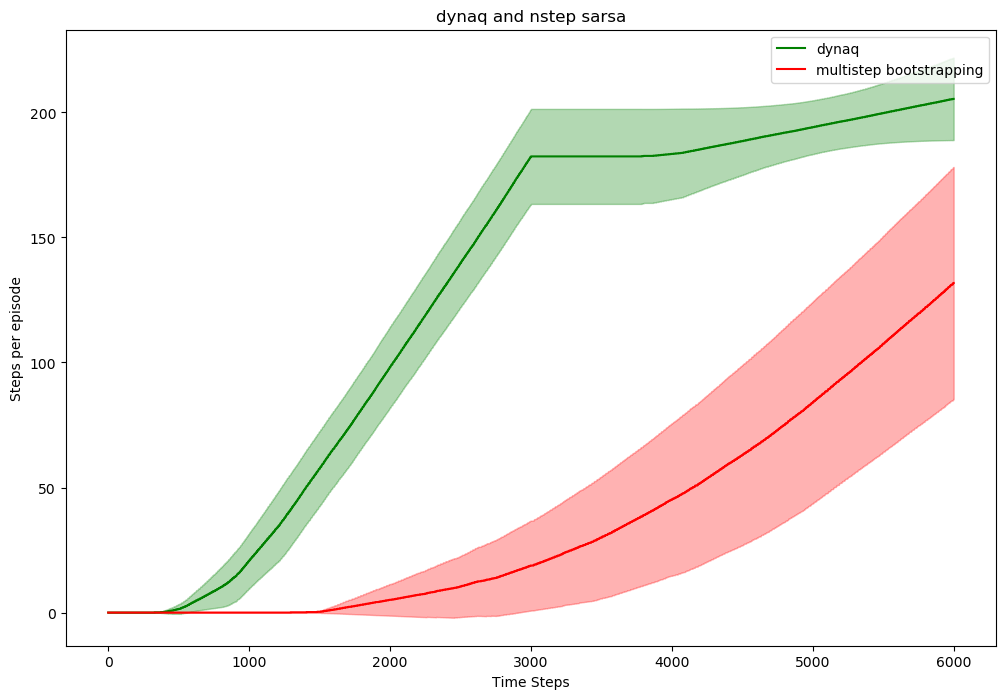

In [195]:
""" Great! You have successfully implement Dyna-Q and Dyna-Q+.
    To reproduce the Figure 8.5, just change the environment to be ShortcutMaze. 
    
    It takes on average 2 mins on a Macbook Pro with M1. 
"""

if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params1 = {
        "switch_time_step": 3000,
        "learning_step": 6000,
        "planning_step": 50,
        "alpha": 0.1,
        "gamma": 0.95,
        "epsilon": 0.1,
        "kappa": 1e-4,
        "episodes":30
    }

    params2 = {
        "switch_time_step": 3000,
        "learning_step": 6000,
        "planning_step": 50,
        "alpha": 0.1,
        "gamma": 0.95,
        "epsilon": 0.1,
        "kappa": 1e-4,
        "episodes":20
    }

    """ Set running trials for experiments 
    """
    run_trial_num = 10

    results_dyna_q_0_steps = []
    reward_nstep=[]
    dynare=[]
    tim=[]
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = BlockingMaze()
        Q,re,epl,tim=n_stepSarsa(my_env,5,30,0.1,1,0.5)
       

        # create the agent for Dyna-Q
        dyna_q_agent =TabularDynaQAgent(my_env,params1)
        result = dyna_q_agent.run()
        reward_nstep.append(tim)

        results_dyna_q_0_steps.append(result)

        sarsaagent =dynavssarsa(my_env,params1)
        resultsarsa = sarsaagent.run()
        reward_nstep.append(resultsarsa)

        dynare.append(resultsarsa)





    plot_curves([np.array(results_dyna_q_0_steps),np.array(dynare)],
                ["dynaq","multistep bootstrapping"],
                ["g", "r"],
                "Steps per episode", "dynaq and nstep sarsa")

In [191]:

class TabularDynaQAgentwithmultibootstrapping(object):
    def __init__(self, env, info):
        # Store the environment
        self.env = env

        # Store the maximal learning steps
        self.k = info['learning_step']

        # Store the planning steps
        self.n = info['planning_step']

        # Store the Q-learning step size alpha
        self.alpha = info['alpha']

        # Store the discount factor
        self.gamma = info['gamma']

        # Initialize the epsilon for epsilon-greedy policy
        self.epsilon = info['epsilon']

        # Initialize the switch time
        self.maze_switch_time = info['switch_time_step']
        # self.plan_rand_gene = np.random.RandomState(info.get('planning_random_seed',42))
        
        # Compute total number of the state
        self.state_num = len(self.env.observation_space)

        # Compute the number of the actions
        self.action_num = len(self.env.action_names)

        # Initialize the Q(s, a): a table stores (s, a)
        self.q_table = np.zeros((self.state_num, self.action_num))
      
        self.model = {}

    def _get_state_idx(self, state):
        """
        Function returns the index of the state in the q table (i.e., row index)
        Args:
             state (tuple): a tuple contains the state
        """
        state = list(state)
        return self.env.observation_space.index(state)

    def _get_action_idx(self, action):
        """
        Function returns the index of the action in the q table (i.e., column index)
        Args:
            action (string): action name
        """
        return self.env.action_names.index(action)

    def epsilon_greedy_policy(self, state):
        """
        Function implements the epsilon-greedy policy
        Args:
            state (tuple): a tuple contains the state
        """
        if random.random() < self.epsilon:  # with p = epsilon, we randomly sample an action
            return random.sample(self.env.action_names, 1)[0]
        else:  # With p = 1 - epsilon, derive a greedy policy from the Q table
            state_idx = self._get_state_idx(state)
            q_values = self.q_table[state_idx]
            max_action_list = np.where(q_values == q_values.max())[0].tolist()
            max_action_idx = random.sample(max_action_list, 1)[0]
            return self.env.action_names[max_action_idx]  # break ties

    def update_model(self, s, a, r, next_s):
        """
        Args:
            s (list): contains the location of the agent
            a (string): name of the action
            r (int): reward
            next_s (list): contains the location of the agent after taking the action
        """
        """ CODE HERE: adding transition to the model """
   
        s=tuple(s)
        next_s=tuple(next_s)
        if s not in self.model:
           
            self.model[s]={}

        self.model[s][a]=(r,next_s)
     
 
    def update_q_table(self, s, a, r, next_s):
        """
        Args:
            s (list): contains the location of the agent
            a (string): name of the action
            r (int): reward
            next_s (list): contains the location of the agent after taking the action
        """
        """ CODE HERE: Q-learning """
    
        s_idx=self._get_state_idx(s)
        next_s_idx=self._get_state_idx(next_s)

        a_idx=self._get_action_idx(a)
        
        max_q= max([self.q_table[next_s_idx][self._get_action_idx(a)] for a in self.env.action_names])

        self.q_table[s_idx][a_idx]=self.q_table[s_idx][a_idx]+self.alpha*(r+self.gamma*max_q-self.q_table[s_idx][a_idx])
        
    def run_planning_step(self):
        """ CODE HERE: planning step see (f) in the pseudocode """
        for _ in range(self.n):
            
            mylist=list(self.model.keys())
            state = mylist.pop(random.randrange(len(mylist)))
            state=tuple(state)
           
            action = random.sample(list(self.model[state].keys()), 1)[0]
         
            reward, next_state = self.model[state][action]
            next_state=tuple(next_state)

            self.update_q_table(state, action, reward, next_state)

    def run(self):

    
        # record the reward
        cumulative_reward = 0
        n=30  # number of plannig steps

        # save the cumulative reward w.r.t. each time step
        cumulative_rewards_wrt_time_steps = np.zeros(self.k)

        # Dyna-Q starts
        state, _ = self.env.reset()
        state=tuple(state)
        
        for t in range(self.k):
           
            action=self.epsilon_greedy_policy(state)
            # take the action and observe reward and next state
            next_state, reward, terminated ,_,_= self.env.step(action)
            next_state=tuple(next_state)
            
            # new_action=self.epsilon_greedy_policy(next_state)
    
            self.update_q_table(state,action,reward,next_state)

            self.update_model(state,action,reward,next_state)
            for i in range(n):

                self.run_planning_step()
            
            """ SAVE PLOTTING RESULTS DO NOT CHANGE """
            # store the cumulative rewards
            cumulative_reward += reward
            cumulative_rewards_wrt_time_steps[t] = cumulative_reward

            if t == self.maze_switch_time:
                state, _ = self.env.reset(shift_maze="right")
            else:
                if terminated:
                    state, _ = self.env.reset()
                    
                else:
                    state = next_state
              

        return cumulative_rewards_wrt_time_steps

100%|██████████| 10/10 [20:37<00:00, 123.72s/it]


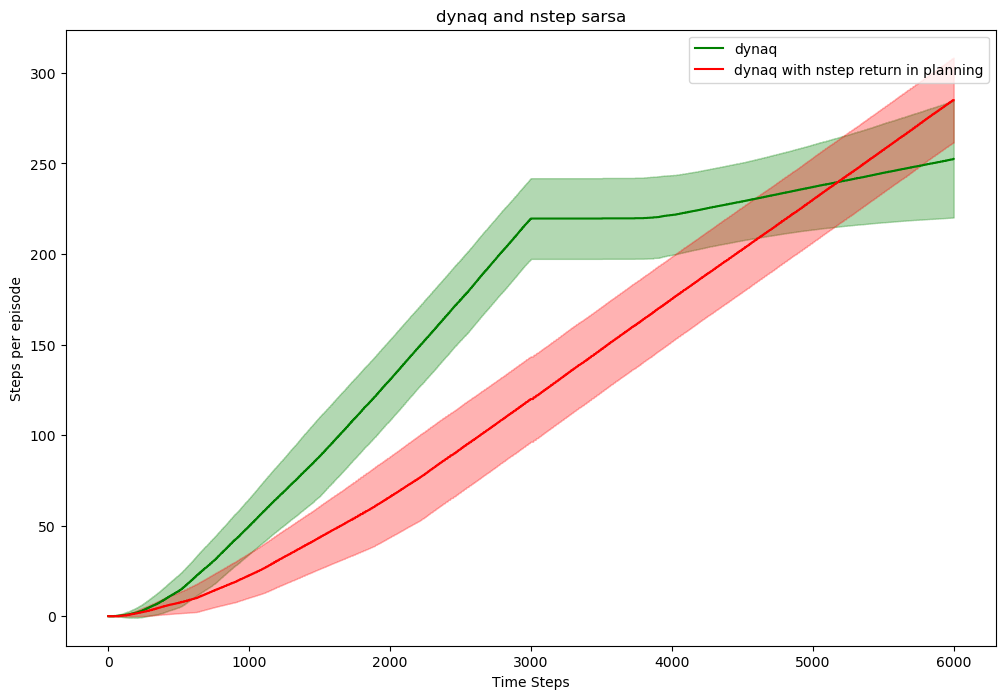

In [193]:
""" Great! You have successfully implement Dyna-Q and Dyna-Q+.
    To reproduce the Figure 8.5, just change the environment to be ShortcutMaze. 
    
    It takes on average 2 mins on a Macbook Pro with M1. 
"""

if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params1 = {
        "switch_time_step": 3000,
        "learning_step": 6000,
        "planning_step": 50,
        "alpha": 0.1,
        "gamma": 0.95,
        "epsilon": 0.1,
        "kappa": 1e-4,
        "episodes":30
    }


    """ Set running trials for experiments 
    """
    run_trial_num = 10

    results_dyna_q_0_steps = []
    reward_nstep=[]
    dynare=[]
    tim=[]
    for r in tqdm.trange(run_trial_num):
        # create the environment
        my_env = BlockingMaze()
        Q,re,epl,tim=n_stepSarsa(my_env,5,30,0.1,1,0.5)
       

        # create the agent for Dyna-Q
        dyna_q_agent =TabularDynaQAgent(my_env,params1)
        result = dyna_q_agent.run()
        reward_nstep.append(tim)

        results_dyna_q_0_steps.append(result)

        sarsaagent =TabularDynaQAgentwithmultibootstrapping(my_env,params1)
        resultsarsa = sarsaagent.run()
        reward_nstep.append(resultsarsa)

        dynare.append(resultsarsa)





    plot_curves([np.array(results_dyna_q_0_steps),np.array(dynare)],
                ["dynaq","dynaq with nstep return in planning"],
                ["g", "r"],
                "Steps per episode", "dynaq and nstep sarsa")